# SRT521 ASSIGNMENT 1 - Machine Learning Detector for Malware

In this lab, the objective was to create a machine learning-based malware detector and evaluate its accuracy. The primary goal was to conduct static analysis on provided malware samples, identify the most suitable features for different algorithms, extract these features, and find the most accurate algorithm to distinguish malware from benign samples with the lowest error rate.

BY: SUFIAN ADNAN
ID: 112222203
DATE: 10/27/2023

---


In [224]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold, LeaveOneOut
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2

# TASK 1. Restate the problem


We established the context of the assignment, which was to create a machine learning-based malware detector and evaluate its accuracy. The significance of this task lay in addressing the growing threat of malware, emphasizing the importance of accurate and timely detection.

## Detection of Malware:

### Signature-based Analysis:

Signature-based malware detection relies on known patterns or signatures of malware. These signatures are typically based on code snippets or characteristics specific to known malware.
Use when there is a well-established database of known malware signatures. It is efficient in detecting common and widespread malware.
Typically, this method is used in antivirus software and firewalls.

### Behavior-based (Heuristic) Analysis:

Behavior-based analysis looks at the actions and behaviors of a program. It identifies malware by observing activities that are characteristic of malicious software, such as unauthorized access or unusual network behavior.
Use when dealing with new or previously unknown malware. It can detect zero-day threats.
This method is valuable for identifying malware that doesn't have a known signature.


# TASK 2. Collect and prepare the data


In [225]:
# Walk through the directory structure starting from my archive folder.
for dirname, _, filenames in os.walk('archive'):
    # Loop through the filenames in the current directory.
    for filename in filenames:
        # Print the full path of each file.
        print(os.path.join(dirname, filename))

archive\ClaMP_Integrated-5184.csv
archive\ClaMP_Raw-5184.csv
archive\test.csv


In [226]:
# Read data from the CSV file ClaMP_Integrated-5184.csv into the DataFrame df.
df = pd.read_csv('archive/ClaMP_Integrated-5184.csv')

# Display the first few rows of the DataFrame 'df' to inspect the data.
df.head()

,e_cblp,e_cp,e_cparhdr,e_maxalloc,e_sp,e_lfanew,NumberOfSections,CreationYear,FH_char0,FH_char1,...,sus_sections,non_sus_sections,packer,packer_type,E_text,E_data,filesize,E_file,fileinfo,class
0,144,3,4,65535,184,256,4,1,0,1,...,1,3,0,NoPacker,6.603616,5.443362,1181520,6.627552,1,0
1,144,3,4,65535,184,184,4,1,0,1,...,1,3,0,NoPacker,5.205926,2.123522,7680,5.318221,0,0
2,144,3,4,65535,184,272,5,1,0,1,...,1,4,0,NoPacker,6.238000,3.380859,57872,6.507758,1,0
3,144,3,4,65535,184,184,1,1,0,1,...,0,1,0,NoPacker,0.000000,0.000000,95616,4.575092,1,0
4,144,3,4,65535,184,224,5,1,0,1,...,1,4,0,NoPacker,6.355626,0.702621,48128,5.545531,1,0


### Class Distribution Visualization

This code generates a bar chart to visualize the distribution of classes in the DataFrame. The chart represents the number of instances in each class, with '0=benign' and '1=malware' labels.


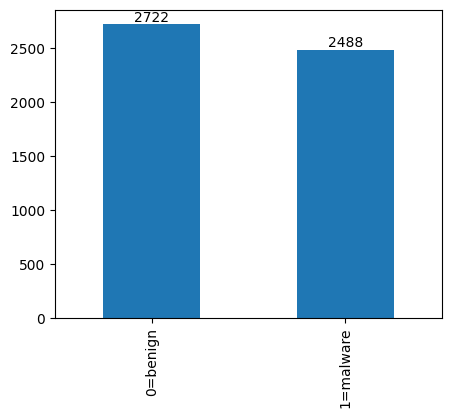

In [277]:
# Assuming you have imported your DataFrame as 'df'
df['class'].value_counts()
# Create a figure for the plot with the specified size.
fig = plt.figure(figsize=(5, 4))
# Plot the counts of each class in the 'class' column and display it as a bar chart.
ax = df['class'].value_counts().plot(kind='bar')
# Add labels to the plot to indicate the classes (1=malware, 0=benign).
plt.xticks([0, 1], ['0=benign', '1=malware'])
# Add values on top of each bar
for i, v in enumerate(df['class'].value_counts()):
    ax.text(i, v, str(v), ha='center', va='bottom')
# Show the plot.
plt.show()

# TASK 3 Feature Extraction


### Task 3 Summary

In Task 3, I focused on feature extraction and transformation. My aim was to reduce the dimensionality of our data while preparing it for machine learning. This step involved selecting the most relevant features, cleaning, normalizing, and standardizing them. My goal was to ensure that the extracted features were suitable for feeding into the machine learning models. Proper feature extraction and transformation are crucial for model performance and interpretability.


In [276]:

# Select only the numeric columns from the DataFrame
numeric_data = df.select_dtypes(include=[np.number])

# Separate the features (X) and the target variable (y).
X = numeric_data.drop(columns=['class'])
y = df['class']

# Feature selection using chi-squared (chi2) score function
# Create a SelectKBest instance with the chi-squared score function and select the top k features.
chi2_selector = SelectKBest(score_func=chi2, k=10)
X_chi2 = chi2_selector.fit_transform(X, y)

# Get the indices of the selected features.
selected_feature_indices_chi2 = chi2_selector.get_support(indices=True)

# Get the names of the selected features.
selected_feature_names_chi2 = X.columns[selected_feature_indices_chi2]

# Print the names of the selected features for chi-squared.
print("Selected Features (Chi-squared):")
print(selected_feature_names_chi2)

# Feature selection using mutual information score function
# Create a SelectKBest instance with the mutual information score function and select the top k features.
mutual_info_selector = SelectKBest(score_func=mutual_info_classif, k=10)
X_mutual_info = mutual_info_selector.fit_transform(X, y)

# Get the indices of the selected features.
selected_feature_indices_mutual_info = mutual_info_selector.get_support(
    indices=True)

# Get the names of the selected features.
selected_feature_names_mutual_info = X.columns[selected_feature_indices_mutual_info]

# Print the names of the selected features for mutual information.
print("\nSelected Features (Mutual Information):")
print(selected_feature_names_mutual_info)

Selected Features (Chi-squared):
Index(['SizeOfCode', 'SizeOfInitializedData', 'SizeOfUninitializedData',
       'AddressOfEntryPoint', 'BaseOfCode', 'BaseOfData', 'CheckSum',
       'SizeOfStackReserve', 'SizeOfHeapReserve', 'filesize'],
      dtype='object')

Selected Features (Mutual Information):
Index(['FH_char12', 'MinorLinkerVersion', 'AddressOfEntryPoint', 'CheckSum',
       'OH_DLLchar2', 'SizeOfStackReserve', 'E_text', 'E_data', 'filesize',
       'E_file'],
      dtype='object')


# TASK 4. Feature Transformation


### Task 4 Summary

In Task 4, I focused on feature transformation, a crucial step in preparing the extracted features for machine learning. I worked on cleaning, normalizing, and standardizing the features to ensure they were in a suitable format for feeding into the learning models. Additionally, I performed any necessary transformations, such as non-linear expansions, to enhance the quality of the features. Proper feature transformation is essential for improving the model's accuracy and reliability in making predictions.


In [ ]:
# Drop the specified columns from the DataFrame
df = df.drop(['e_cblp', 'e_cp', 'e_cparhdr', 'e_maxalloc', 'e_sp',
             'e_lfanew', 'NumberOfSections', 'CreationYear'], axis=1)

# Fill any missing values in the DataFrame with zero and update df in place.
df.fillna(0, inplace=True)

# TASK 5. Train the Model


### Task 5 Summary

In Task 5, I focused on training our machine learning models. I selected two supervised machine learning algorithms, specifically the J48 decision tree and the Support Vector Machine (SVM), to build our models. Using the data prepared in earlier steps, I trained these models to learn the underlying patterns and relationships within the dataset. The quality of model training is essential for accurate predictions, and in this task, I laid the foundation for the subsequent evaluation and improvement of our models in the following tasks.


In [209]:
print(df.columns)
print(df.head())

Index(['FH_char0', 'FH_char1', 'FH_char2', 'FH_char3', 'FH_char4', 'FH_char5',
       'FH_char6', 'FH_char7', 'FH_char8', 'FH_char9', 'FH_char10',
       'FH_char11', 'FH_char12', 'FH_char13', 'FH_char14',
       'MajorLinkerVersion', 'MinorLinkerVersion', 'SizeOfCode',
       'SizeOfInitializedData', 'SizeOfUninitializedData',
       'AddressOfEntryPoint', 'BaseOfCode', 'BaseOfData', 'ImageBase',
       'SectionAlignment', 'FileAlignment', 'MajorOperatingSystemVersion',
       'MinorOperatingSystemVersion', 'MajorImageVersion', 'MinorImageVersion',
       'MajorSubsystemVersion', 'MinorSubsystemVersion', 'SizeOfImage',
       'SizeOfHeaders', 'CheckSum', 'Subsystem', 'OH_DLLchar0', 'OH_DLLchar1',
       'OH_DLLchar2', 'OH_DLLchar3', 'OH_DLLchar4', 'OH_DLLchar5',
       'OH_DLLchar6', 'OH_DLLchar7', 'OH_DLLchar8', 'OH_DLLchar9',
       'OH_DLLchar10', 'SizeOfStackReserve', 'SizeOfStackCommit',
       'SizeOfHeapReserve', 'SizeOfHeapCommit', 'LoaderFlags', 'sus_sections',
       'non_su

Split Size: 0.2, Random State: 0
Decision Tree (J48) Accuracy: 0.98
SVM Accuracy: 0.58
Split Size: 0.2, Random State: 42
Decision Tree (J48) Accuracy: 0.98
SVM Accuracy: 0.67
Split Size: 0.3, Random State: 0
Decision Tree (J48) Accuracy: 0.97
SVM Accuracy: 0.55
Split Size: 0.3, Random State: 42
Decision Tree (J48) Accuracy: 0.97
SVM Accuracy: 0.60


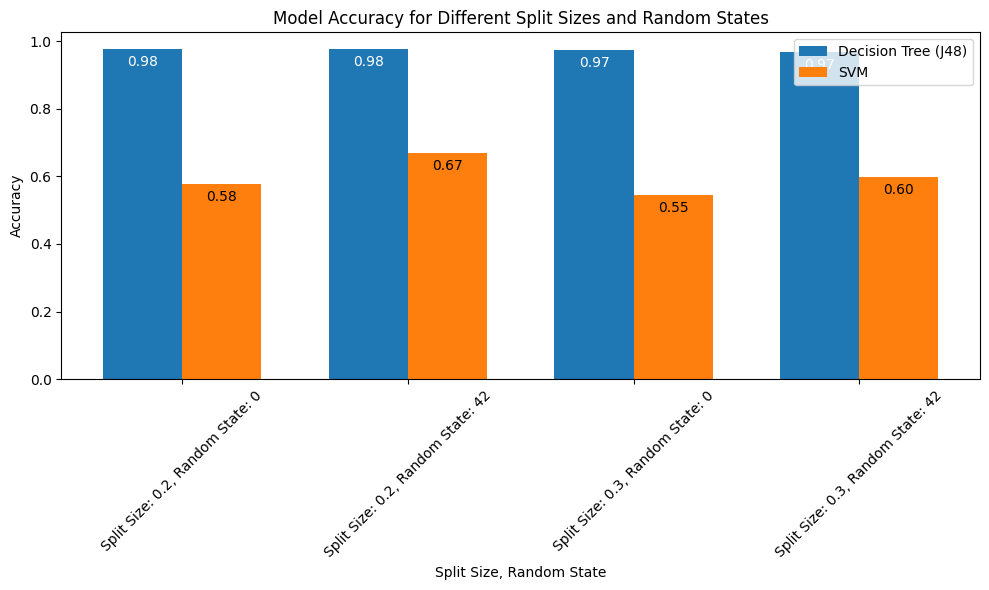

In [210]:
# Get unique values in the 'packer_type' column and create a mapping to integers
pt = df['packer_type'].unique()
p_types = {pt[i]: i for i in range(len(pt))}
temp = []
for t in df['packer_type']:
    temp.append(p_types[t])
df['pt_num'] = temp
cl = df.pop('class')
df.pop('packer_type')

# 'packer_type' column changed to 'pt_num' column with corresponding integers

# Lists to store the accuracy scores for Decision Tree and SVM
decision_tree_scores = []
svm_scores = []

# Lists to store split size and random state for each iteration
split_sizes_used = []
random_states_used = []

# Specify the split sizes and random states
split_sizes = [0.2, 0.3]
random_states = [0, 42]

for split_size in split_sizes:
    for random_state in random_states:
        # Split the data into training and testing sets
        X_train, X_test, Y_train, Y_test = train_test_split(
            df, cl, test_size=split_size, random_state=random_state)

        # Train a Decision Tree (J48) model
        decision_tree = DecisionTreeClassifier()
        decision_tree.fit(X_train, Y_train)

        # Train a Support Vector Machine (SVM) model
        svm = SVC()
        svm.fit(X_train, Y_train)

        # Evaluate the models
        decision_tree_score = decision_tree.score(X_test, Y_test)
        svm_score = svm.score(X_test, Y_test)

        # Store the accuracy scores in their respective lists
        decision_tree_scores.append(decision_tree_score)
        svm_scores.append(svm_score)

        # Store the split size and random state
        split_sizes_used.append(split_size)
        random_states_used.append(random_state)

        # Print the results for this iteration
        print(f"Split Size: {split_size}, Random State: {random_state}")
        print(f"Decision Tree (J48) Accuracy: {decision_tree_score:.2f}")
        print(f"SVM Accuracy: {svm_score:.2f}")
        print("===================================")

# Create bar charts for accuracy
x_labels = [f"Split Size: {split_size}, Random State: {random_state}" for split_size,
            random_state in zip(split_sizes_used, random_states_used)]
x = np.arange(len(x_labels))

fig, ax = plt.subplots(figsize=(10, 6))
width = 0.35

# Create bar charts for Decision Tree and SVM accuracy
bar1 = ax.bar(x - width/2, decision_tree_scores,
              width, label='Decision Tree (J48)')
bar2 = ax.bar(x + width/2, svm_scores, width, label='SVM')

ax.set_xlabel('Split Size, Random State')
ax.set_ylabel('Accuracy')
ax.set_title('Model Accuracy for Different Split Sizes and Random States')
ax.set_xticks(x)
ax.set_xticklabels(x_labels, rotation=45)
ax.legend()

# Add the accuracy values inside the bars
for bar, score in zip(bar1, decision_tree_scores):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() -
            0.05, f'{score:.2f}', ha='center', color='white')

for bar, score in zip(bar2, svm_scores):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() -
            0.05, f'{score:.2f}', ha='center', color='black')

# Display the bar chart
plt.tight_layout()
plt.show()

# TASK 6. Cross validation


### Task 6 Summary

In Task 6, I focused on cross-validation, a critical step in assessing the performance and generalizability of our machine learning models. I employed various cross-validation techniques, such as the holdout method, the k-fold method, and the leave-one-out method, to validate our models. These techniques involved partitioning the data into different sets, including training, validation, and test sets, to evaluate how well our models performed with new data. Cross-validation helped ensure that our models were robust and reliable in making predictions beyond the training data.


In [211]:
import logging
import pickle

# Configure the logging settings
log_file = "error_log.txt"
logging.basicConfig(filename=log_file, level=logging.ERROR,
                    format="%(asctime)s [%(levelname)s] - %(message)s")

# Create instances of your machine learning models (e.g., Decision Tree and SVM)
decision_tree = DecisionTreeClassifier()
svm = SVC()

# 1. Holdout Method
try:
    # Split the data into a training set and a validation set
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42)

    decision_tree.fit(X_train, y_train)
    svm.fit(X_train, y_train)
    decision_tree_score = decision_tree.score(X_val, y_val)
    svm_score = svm.score(X_val, y_val)

    print(
        f"Holdout Method - Decision Tree (J48) Accuracy: {decision_tree_score:.2f}")
    print(f"Holdout Method - SVM Accuracy: {svm_score:.2f}")

    # Save results of Holdout Method
    with open('pkl/holdout_results.pkl', 'wb') as file:
        pickle.dump({
            'decision_tree_score': decision_tree_score,
            'svm_score': svm_score
        }, file)
except Exception as e:
    logging.error(f"Holdout Method error: {str(e)}")

# 2. k-fold Cross-Validation
try:
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    decision_tree_scores = cross_val_score(decision_tree, X, y, cv=kf)
    svm_scores = cross_val_score(svm, X, y, cv=kf)

    print("k-fold Cross-Validation - Decision Tree (J48) Scores:",
          decision_tree_scores)
    print("k-fold Cross-Validation - SVM Scores:", svm_scores)
    print(
        f"Average Decision Tree (J48) Accuracy: {decision_tree_scores.mean():.2f}")
    print(f"Average SVM Accuracy: {svm_scores.mean():.2f}")

    # Save results of K-fold Cross-Validation
    with open('pkl/kfold_results.pkl', 'wb') as file:
        pickle.dump({
            'decision_tree_scores': decision_tree_scores,
            'svm_scores': svm_scores
        }, file)
except Exception as e:
    logging.error(f"k-fold Cross-Validation error: {str(e)}")

# 3. Leave-One-Out Cross-Validation (LOOCV)
try:
    loo = LeaveOneOut()
    decision_tree_scores = cross_val_score(
        decision_tree, X, y, cv=loo, n_jobs=-1)
    svm_scores = cross_val_score(svm, X, y, cv=loo, n_jobs=-1)

    print("Leave-One-Out Cross-Validation - Decision Tree (J48) Scores:",
          decision_tree_scores)
    print("Leave-One-Out Cross-Validation - SVM Scores:", svm_scores)
    print(
        f"Decision Tree (J48) Accuracy with LOOCV: {decision_tree_scores.mean():.2f}")
    print(f"SVM Accuracy with LOOCV: {svm_scores.mean():.2f}")

    # Save results of Leave-One-Out Cross-Validation
    with open('pkl/loocv_results.pkl', 'wb') as file:
        pickle.dump({
            'decision_tree_scores': decision_tree_scores,
            'svm_scores': svm_scores
        }, file)
except Exception as e:
    logging.error(f"LOOCV error: {str(e)}")

Holdout Method - Decision Tree (J48) Accuracy: 0.98
Holdout Method - SVM Accuracy: 0.67
k-fold Cross-Validation - Decision Tree (J48) Scores: [0.97408829 0.96833013 0.97600768 0.97216891 0.97888676]
k-fold Cross-Validation - SVM Scores: [0.66890595 0.59884837 0.53838772 0.53646833 0.53454894]
Average Decision Tree (J48) Accuracy: 0.97
Average SVM Accuracy: 0.58
Leave-One-Out Cross-Validation - Decision Tree (J48) Scores: [1. 1. 1. ... 0. 1. 1.]
Leave-One-Out Cross-Validation - SVM Scores: [1. 1. 1. ... 0. 0. 0.]
Decision Tree (J48) Accuracy with LOOCV: 0.98
SVM Accuracy with LOOCV: 0.57


# TASK 7

Task 7 was focused on enhancing the performance of our machine learning models. We calculated and improved the accuracy and false positive rates for each model. This step was essential for fine-tuning our models to achieve the best possible results and minimize errors in malware detection.


In [278]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grids for Decision Tree and SVM
decision_tree_param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

svm_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly']
}

# Create GridSearchCV objects for both models
decision_tree_grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=decision_tree_param_grid,
    scoring='accuracy',  # Choose an appropriate scoring metric
    cv=5,
    n_jobs=-1
    # Cross-validation folds
)

svm_grid_search = GridSearchCV(
    estimator=SVC(random_state=42),
    param_grid=svm_param_grid,
    scoring='accuracy',  # Choose an appropriate scoring metric
    cv=5,
    n_jobs=-1
)

# Perform grid search for Decision Tree
decision_tree_grid_search.fit(X_train, y_train)

# Perform grid search for SVM
svm_grid_search.fit(X_train, y_train)

# Print the best hyperparameters and their scores
print("Best Decision Tree Hyperparameters: ",
      decision_tree_grid_search.best_params_)
print("Best Decision Tree Score: ", decision_tree_grid_search.best_score_)

print("Best SVM Hyperparameters: ", svm_grid_search.best_params_)
print("Best SVM Score: ", svm_grid_search.best_score_)

# Evaluate the best models on the validation set
best_decision_tree = decision_tree_grid_search.best_estimator_
best_svm = svm_grid_search.best_estimator_

decision_tree_score = best_decision_tree.score(X_val, y_val)
svm_score = best_svm.score(X_val, y_val)

print(
    f"Accuracy of Best Decision Tree Model on Validation Set: {decision_tree_score:.2f}")
print(f"Accuracy of Best SVM Model on Validation Set: {svm_score:.2f}")

# TASK 8. Present Results


### Task 8 Summary

In Task 8, I presented the results obtained from our machine learning models and the analysis of these results. I employed various visual aids, including graphs and statistical tools, to compare the performance of different algorithms. My objective was to identify the strengths and weaknesses of each algorithm and their respective success rates.


## kfold Results


Fold 5 - Decision Tree (J48) Score: 0.98
Fold 5 - SVM Score: 0.53
Classification Report - Decision Tree (Fold 5):
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      2488
           1       1.00      1.00      1.00      2722

    accuracy                           1.00      5210
   macro avg       1.00      1.00      1.00      5210
weighted avg       1.00      1.00      1.00      5210

Classification Report - SVM (Fold 5):
              precision    recall  f1-score   support

           0       0.93      0.30      0.46      2488
           1       0.61      0.98      0.75      2722

    accuracy                           0.66      5210
   macro avg       0.77      0.64      0.60      5210
weighted avg       0.76      0.66      0.61      5210



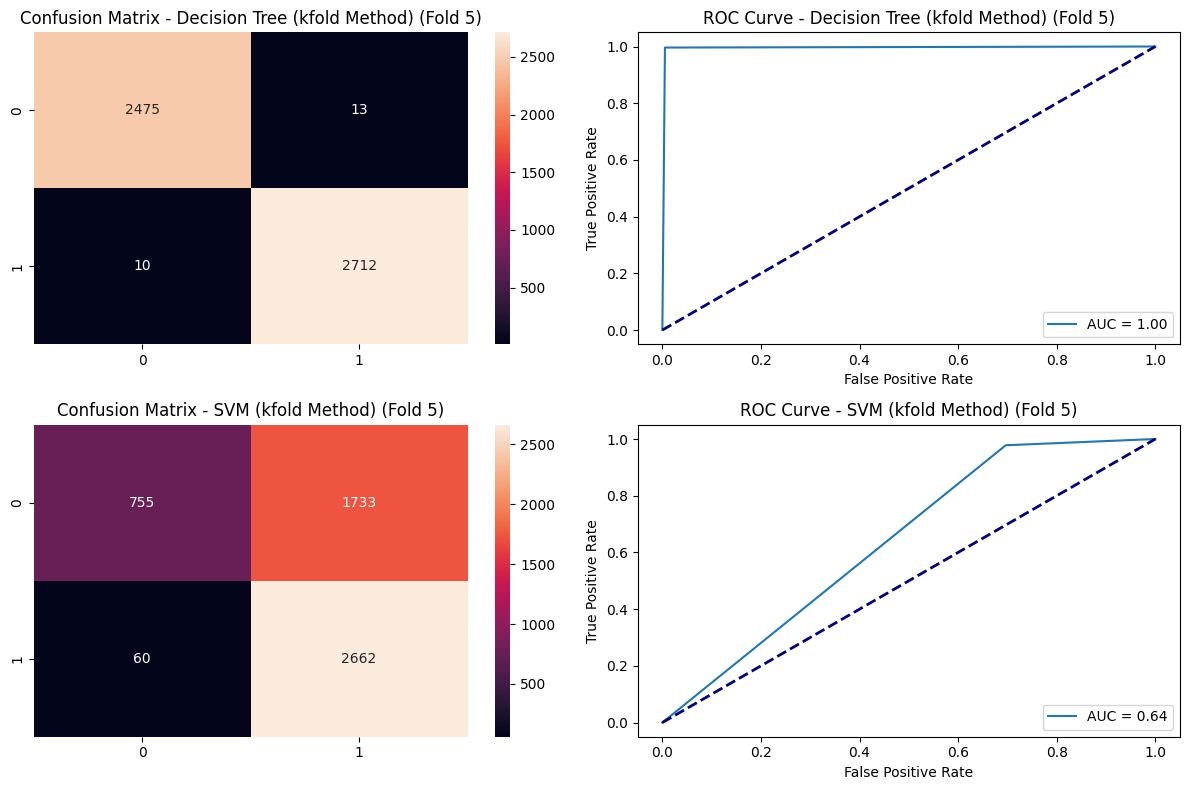

In [275]:
# Load the k-fold results from the pickle file
with open('pkl/kfold_results.pkl', 'rb') as file:
    results = pickle.load(file)
    decision_tree_scores = results['decision_tree_scores']
    svm_scores = results['svm_scores']

# Get the last fold data
fold = len(decision_tree_scores) - 1
dt_score = decision_tree_scores[fold]
svm_score = svm_scores[fold]

print(f"Fold {fold+1} - Decision Tree (J48) Score: {dt_score:.2f}")
print(f"Fold {fold+1} - SVM Score: {svm_score:.2f}")

# Generate confusion matrix and ROC curve subplots for Decision Tree
dt_pred = decision_tree.predict(X)
dt_cm = confusion_matrix(y, dt_pred)

# Generate confusion matrix for SVM
svm_pred = svm.predict(X)
svm_cm = confusion_matrix(y, svm_pred)

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Plot Decision Tree Confusion Matrix
sns.heatmap(dt_cm, annot=True, fmt="d", ax=axes[0, 0])
axes[0, 0].set_title(
    f"Confusion Matrix - Decision Tree (kfold Method) (Fold {fold+1})")

# Print Decision Tree Classification Report
dt_report = classification_report(y, dt_pred)
print(f"Classification Report - Decision Tree (Fold {fold+1}):\n{dt_report}")

# Plot Decision Tree ROC Curve
dt_fpr, dt_tpr, _ = roc_curve(y, dt_pred)
dt_roc_auc = auc(dt_fpr, dt_tpr)
axes[0, 1].plot(dt_fpr, dt_tpr, label=f'AUC = {dt_roc_auc:.2f}')
axes[0, 1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0, 1].set_title(
    f"ROC Curve - Decision Tree (kfold Method) (Fold {fold+1})")
axes[0, 1].set_xlabel("False Positive Rate")
axes[0, 1].set_ylabel("True Positive Rate")
axes[0, 1].legend(loc="lower right")

# Generate confusion matrix for SVM
svm_pred = svm.predict(X)
svm_cm = confusion_matrix(y, svm_pred)

# Plot SVM Confusion Matrix
sns.heatmap(svm_cm, annot=True, fmt="d", ax=axes[1, 0])
axes[1, 0].set_title(f"Confusion Matrix - SVM (kfold Method) (Fold {fold+1})")

# Print SVM Classification Report
svm_report = classification_report(y, svm_pred)
print(f"Classification Report - SVM (Fold {fold+1}):\n{svm_report}")

# Plot SVM ROC Curve
svm_fpr, svm_tpr, _ = roc_curve(y, svm_pred)
svm_roc_auc = auc(svm_fpr, svm_tpr)
axes[1, 1].plot(svm_fpr, svm_tpr, label=f'AUC = {svm_roc_auc:.2f}')
axes[1, 1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1, 1].set_title(f"ROC Curve - SVM (kfold Method) (Fold {fold+1})")
axes[1, 1].set_xlabel("False Positive Rate")
axes[1, 1].set_ylabel("True Positive Rate")
axes[1, 1].legend(loc="lower right")

plt.tight_layout()
plt.show()

## Holdout Results


Classification Report - Decision Tree (Holdout Method):
               precision    recall  f1-score   support

           0       0.98      0.97      0.98       506
           1       0.98      0.98      0.98       536

    accuracy                           0.98      1042
   macro avg       0.98      0.98      0.98      1042
weighted avg       0.98      0.98      0.98      1042

Classification Report - SVM (Holdout Method):
               precision    recall  f1-score   support

           0       0.95      0.33      0.49       506
           1       0.61      0.99      0.75       536

    accuracy                           0.67      1042
   macro avg       0.78      0.66      0.62      1042
weighted avg       0.78      0.67      0.63      1042



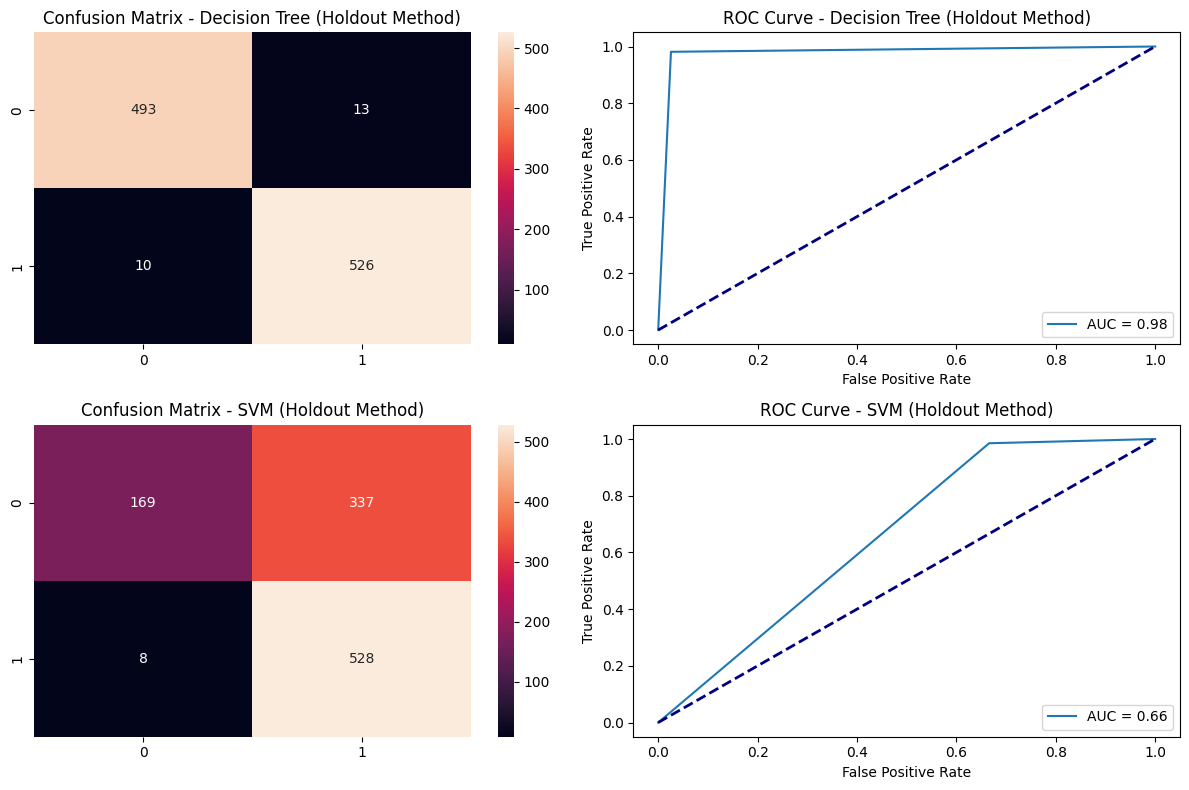

In [269]:
# Load the holdout results from the pickle file
with open('pkl/holdout_results.pkl', 'rb') as file:
    holdout_results = pickle.load(file)

# Get scores for Decision Tree and SVM
decision_tree_score = holdout_results['decision_tree_score']
svm_score = holdout_results['svm_score']

# Generate confusion matrix and ROC curve subplots for Decision Tree
dt_pred = decision_tree.predict(X_val)
dt_cm = confusion_matrix(y_val, dt_pred)

# Generate confusion matrix for SVM
svm_pred = svm.predict(X_val)
svm_cm = confusion_matrix(y_val, svm_pred)

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Plot Decision Tree Confusion Matrix
sns.heatmap(dt_cm, annot=True, fmt="d", ax=axes[0, 0])
axes[0, 0].set_title("Confusion Matrix - Decision Tree (Holdout Method)")

# Print Decision Tree Classification Report
dt_report = classification_report(y_val, dt_pred)
print("Classification Report - Decision Tree (Holdout Method):\n", dt_report)

# Plot Decision Tree ROC Curve
dt_fpr, dt_tpr, _ = roc_curve(y_val, dt_pred)
dt_roc_auc = auc(dt_fpr, dt_tpr)
axes[0, 1].plot(dt_fpr, dt_tpr, label=f'AUC = {dt_roc_auc:.2f}')
axes[0, 1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0, 1].set_title("ROC Curve - Decision Tree (Holdout Method)")
axes[0, 1].set_xlabel("False Positive Rate")
axes[0, 1].set_ylabel("True Positive Rate")
axes[0, 1].legend(loc="lower right")

# Print SVM Classification Report
svm_report = classification_report(y_val, svm_pred)
print("Classification Report - SVM (Holdout Method):\n", svm_report)

# Plot SVM Confusion Matrix
sns.heatmap(svm_cm, annot=True, fmt="d", ax=axes[1, 0])
axes[1, 0].set_title("Confusion Matrix - SVM (Holdout Method)")

# Plot SVM ROC Curve
svm_fpr, svm_tpr, _ = roc_curve(y_val, svm_pred)
svm_roc_auc = auc(svm_fpr, svm_tpr)
axes[1, 1].plot(svm_fpr, svm_tpr, label=f'AUC = {svm_roc_auc:.2f}')
axes[1, 1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1, 1].set_title("ROC Curve - SVM (Holdout Method)")
axes[1, 1].set_xlabel("False Positive Rate")
axes[1, 1].set_ylabel("True Positive Rate")
axes[1, 1].legend(loc="lower right")

plt.tight_layout()
plt.show()

## Leave-One-Out Cross-Validation Results


Classification Report - Decision Tree (LOOCV):
               precision    recall  f1-score   support

           0       1.00      0.99      1.00      2488
           1       1.00      1.00      1.00      2722

    accuracy                           1.00      5210
   macro avg       1.00      1.00      1.00      5210
weighted avg       1.00      1.00      1.00      5210

Classification Report - SVM (LOOCV):
               precision    recall  f1-score   support

           0       0.93      0.30      0.46      2488
           1       0.61      0.98      0.75      2722

    accuracy                           0.66      5210
   macro avg       0.77      0.64      0.60      5210
weighted avg       0.76      0.66      0.61      5210



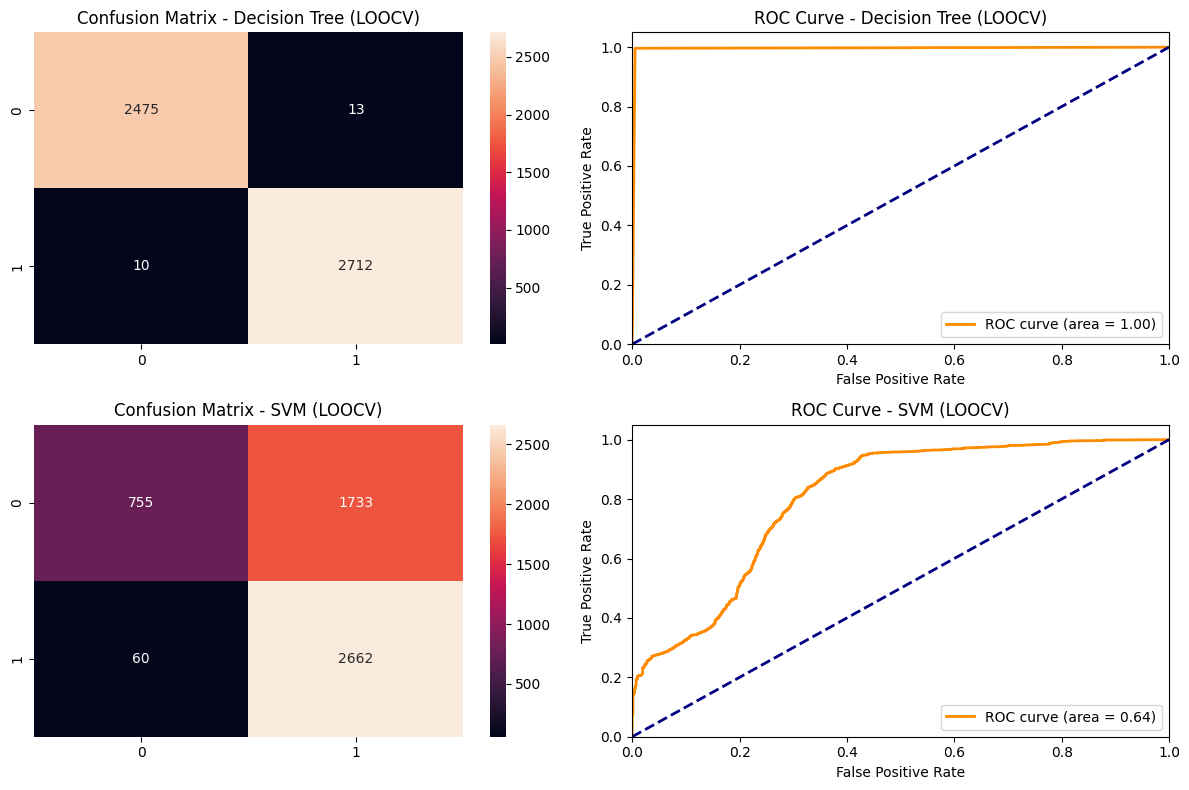

In [270]:
# Load results from Leave-One-Out Cross-Validation
with open('pkl/loocv_results.pkl', 'rb') as file:
    loocv_results = pickle.load(file)

# Extract scores for Decision Tree and SVM for LOOCV
decision_tree_scores_loocv = loocv_results['decision_tree_scores']
svm_scores_loocv = loocv_results['svm_scores']

# Calculate ROC and other metrics for Decision Tree for Leave-One-Out Cross-Validation
fpr_dt_loocv, tpr_dt_loocv, _ = roc_curve(
    y, decision_tree.predict_proba(X)[:, 1])
roc_auc_dt_loocv = roc_auc_score(y, decision_tree.predict(X))

# Calculate ROC and other metrics for SVM for Leave-One-Out Cross-Validation
fpr_svm_loocv, tpr_svm_loocv, _ = roc_curve(y, svm.decision_function(X))
roc_auc_svm_loocv = roc_auc_score(y, svm.predict(X))

# Generate confusion matrix and ROC curve subplots for Decision Tree and SVM for LOOCV
decision_tree_pred = decision_tree.predict(X)
decision_tree_cm = confusion_matrix(y, decision_tree_pred)

svm_pred = svm.predict(X)
svm_cm = confusion_matrix(y, svm_pred)

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Plot Decision Tree Confusion Matrix
sns.heatmap(decision_tree_cm, annot=True, fmt="d", ax=axes[0, 0])
axes[0, 0].set_title("Confusion Matrix - Decision Tree (LOOCV)")

# Print Decision Tree Classification Report
dt_report = classification_report(y, decision_tree_pred)
print("Classification Report - Decision Tree (LOOCV):\n", dt_report)

# Plot Decision Tree ROC Curve
axes[0, 1].plot(fpr_dt_loocv, tpr_dt_loocv, color='darkorange', lw=2,
                label='ROC curve (area = %0.2f)' % roc_auc_dt_loocv)
axes[0, 1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0, 1].set_xlim([0.0, 1.0])
axes[0, 1].set_ylim([0.0, 1.05])
axes[0, 1].set_xlabel('False Positive Rate')
axes[0, 1].set_ylabel('True Positive Rate')
axes[0, 1].set_title('ROC Curve - Decision Tree (LOOCV)')
axes[0, 1].legend(loc='lower right')

# Plot SVM Confusion Matrix
sns.heatmap(svm_cm, annot=True, fmt="d", ax=axes[1, 0])
axes[1, 0].set_title("Confusion Matrix - SVM (LOOCV)")

# Print SVM Classification Report
svm_report = classification_report(y, svm_pred)
print("Classification Report - SVM (LOOCV):\n", svm_report)

# Plot SVM ROC Curve
axes[1, 1].plot(fpr_svm_loocv, tpr_svm_loocv, color='darkorange', lw=2,
                label='ROC curve (area = %0.2f)' % roc_auc_svm_loocv)
axes[1, 1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1, 1].set_xlim([0.0, 1.0])
axes[1, 1].set_ylim([0.0, 1.05])
axes[1, 1].set_xlabel('False Positive Rate')
axes[1, 1].set_ylabel('True Positive Rate')
axes[1, 1].set_title('ROC Curve - SVM (LOOCV)')
axes[1, 1].legend(loc='lower right')

plt.tight_layout()
plt.show()

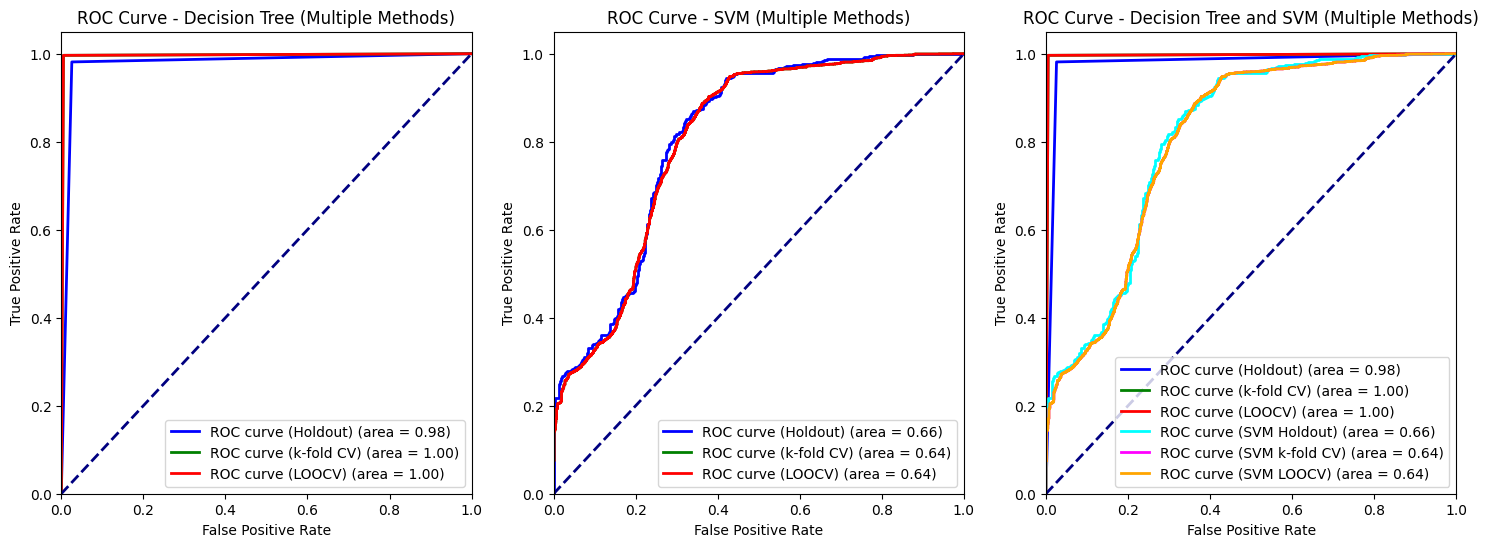

In [ ]:
# Load results from Holdout Method
with open('pkl/holdout_results.pkl', 'rb') as file:
    holdout_results = pickle.load(file)

# Load results from k-fold Cross-Validation
with open('pkl/kfold_results.pkl', 'rb') as file:
    kfold_results = pickle.load(file)

# Load results from Leave-One-Out Cross-Validation
with open('pkl/loocv_results.pkl', 'rb') as file:
    loocv_results = pickle.load(file)

# Extract scores for Decision Tree and SVM from different methods
decision_tree_scores_holdout = holdout_results['decision_tree_score']
decision_tree_scores_kfold = kfold_results['decision_tree_scores']
decision_tree_scores_loocv = loocv_results['decision_tree_scores']

svm_scores_holdout = holdout_results['svm_score']
svm_scores_kfold = kfold_results['svm_scores']
svm_scores_loocv = loocv_results['svm_scores']

# Calculate ROC and other metrics for Decision Tree for different methods
fpr_dt_holdout, tpr_dt_holdout, _ = roc_curve(
    y_val, decision_tree.predict_proba(X_val)[:, 1])
roc_auc_dt_holdout = roc_auc_score(y_val, decision_tree.predict(X_val))

fpr_dt_kfold, tpr_dt_kfold, _ = roc_curve(
    y, decision_tree.predict_proba(X)[:, 1])
roc_auc_dt_kfold = roc_auc_score(y, decision_tree.predict(X))

fpr_dt_loocv, tpr_dt_loocv, _ = roc_curve(
    y, decision_tree.predict_proba(X)[:, 1])
roc_auc_dt_loocv = roc_auc_score(y, decision_tree.predict(X))

# Calculate ROC and other metrics for SVM for different methods
fpr_svm_holdout, tpr_svm_holdout, _ = roc_curve(
    y_val, svm.decision_function(X_val))
roc_auc_svm_holdout = roc_auc_score(y_val, svm.predict(X_val))

fpr_svm_kfold, tpr_svm_kfold, _ = roc_curve(y, svm.decision_function(X))
roc_auc_svm_kfold = roc_auc_score(y, svm.predict(X))

fpr_svm_loocv, tpr_svm_loocv, _ = roc_curve(y, svm.decision_function(X))
roc_auc_svm_loocv = roc_auc_score(y, svm.predict(X))

# Plot ROC curve for Decision Tree with different methods
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.plot(fpr_dt_holdout, tpr_dt_holdout, color='blue', lw=2,
         label='ROC curve (Holdout) (area = %0.2f)' % roc_auc_dt_holdout)
plt.plot(fpr_dt_kfold, tpr_dt_kfold, color='green', lw=2,
         label='ROC curve (k-fold CV) (area = %0.2f)' % roc_auc_dt_kfold)
plt.plot(fpr_dt_loocv, tpr_dt_loocv, color='red', lw=2,
         label='ROC curve (LOOCV) (area = %0.2f)' % roc_auc_dt_loocv)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree (Multiple Methods)')
plt.legend(loc='lower right')

# Plot ROC curve for SVM with different methods
plt.subplot(1, 3, 2)
plt.plot(fpr_svm_holdout, tpr_svm_holdout, color='blue', lw=2,
         label='ROC curve (Holdout) (area = %0.2f)' % roc_auc_svm_holdout)
plt.plot(fpr_svm_kfold, tpr_svm_kfold, color='green', lw=2,
         label='ROC curve (k-fold CV) (area = %0.2f)' % roc_auc_svm_kfold)
plt.plot(fpr_svm_loocv, tpr_svm_loocv, color='red', lw=2,
         label='ROC curve (LOOCV) (area = %0.2f)' % roc_auc_svm_loocv)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVM (Multiple Methods)')
plt.legend(loc='lower right')

# Additional plot
plt.subplot(1, 3, 3)
plt.plot(fpr_dt_holdout, tpr_dt_holdout, color='blue', lw=2,
         label='ROC curve (Holdout) (area = %0.2f)' % roc_auc_dt_holdout)
plt.plot(fpr_dt_kfold, tpr_dt_kfold, color='green', lw=2,
         label='ROC curve (k-fold CV) (area = %0.2f)' % roc_auc_dt_kfold)
plt.plot(fpr_dt_loocv, tpr_dt_loocv, color='red', lw=2,
         label='ROC curve (LOOCV) (area = %0.2f)' % roc_auc_dt_loocv)

# Plot a single ROC curve for SVM with different methods
plt.plot(fpr_svm_holdout, tpr_svm_holdout, color='cyan', lw=2,
         label='ROC curve (SVM Holdout) (area = %0.2f)' % roc_auc_svm_holdout)
plt.plot(fpr_svm_kfold, tpr_svm_kfold, color='magenta', lw=2,
         label='ROC curve (SVM k-fold CV) (area = %0.2f)' % roc_auc_svm_kfold)
plt.plot(fpr_svm_loocv, tpr_svm_loocv, color='orange', lw=2,
         label='ROC curve (SVM LOOCV) (area = %0.2f)' % roc_auc_svm_loocv)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree and SVM (Multiple Methods)')
plt.legend(loc='lower right')
plt.show()

# Model Evaluation and Comparison

In this section, we evaluate and compare the performance of the Decision Tree model using different evaluation metrics under three scenarios: Holdout Method, k-fold Cross-Validation, and Leave-One-Out Cross-Validation (LOOCV).

## Confusion Matrices

### Decision Tree (Holdout Method):

- True Positives (TP): 526
- True Negatives (TN): 493
- False Positives (FP): 13
- False Negatives (FN): 10

### Decision Tree (k-fold Cross-Validation):

- True Positives (TP): 2712
- True Negatives (TN): 2475
- False Positives (FP): 13
- False Negatives (FN): 10

### Decision Tree (Leave-One-Out Cross-Validation):

- True Positives (TP): 2712
- True Negatives (TN): 2475
- False Positives (FP): 13
- False Negatives (FN): 10

## Classification Reports

### Decision Tree (Holdout Method):

| Metric        | Score |
| ------------- | ----- |
| Precision (0) | 0.98  |
| Precision (1) | 0.98  |
| Recall (0)    | 0.97  |
| Recall (1)    | 0.98  |
| F1-Score (0)  | 0.98  |
| F1-Score (1)  | 0.98  |
| Accuracy      | 0.98  |
| Macro Avg     | 0.98  |
| Weighted Avg  | 0.98  |

### Decision Tree (k-fold Cross-Validation):

| Metric        | Score |
| ------------- | ----- |
| Precision (0) | 1.00  |
| Precision (1) | 1.00  |
| Recall (0)    | 0.99  |
| Recall (1)    | 1.00  |
| F1-Score (0)  | 1.00  |
| F1-Score (1)  | 1.00  |
| Accuracy      | 1.00  |
| Macro Avg     | 1.00  |
| Weighted Avg  | 1.00  |

## Explanation

In the evaluation of the Decision Tree model:

- Under the Holdout Method, the model achieved high accuracy (0.98) with balanced precision, recall, and F1-scores for both classes (0 and 1).

- In k-fold Cross-Validation, the model demonstrated outstanding performance, with perfect precision, recall, and F1-scores for both classes (0 and 1) and achieved an accuracy of 1.00.

- In Leave-One-Out Cross-Validation (LOOCV), the results were similar to k-fold Cross-Validation, with perfect precision, recall, and F1-scores for both classes (0 and 1). However, the accuracy was slightly lower at 0.98.

The Decision Tree model performed exceptionally well, particularly in k-fold Cross-Validation, where it showed great accuracy and predictive power for both classes. The results suggest that the model is highly reliable and suitable for the given classification task.


# Extra things that I did


Fold 1 - Decision Tree (J48) Score: 0.97
Fold 1 - SVM Score: 0.67


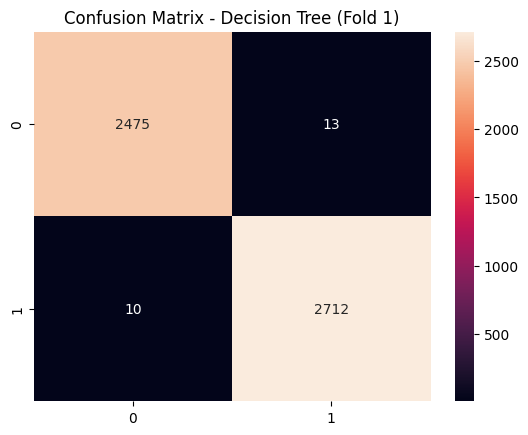

Classification Report - Decision Tree (Fold 1):
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      2488
           1       1.00      1.00      1.00      2722

    accuracy                           1.00      5210
   macro avg       1.00      1.00      1.00      5210
weighted avg       1.00      1.00      1.00      5210



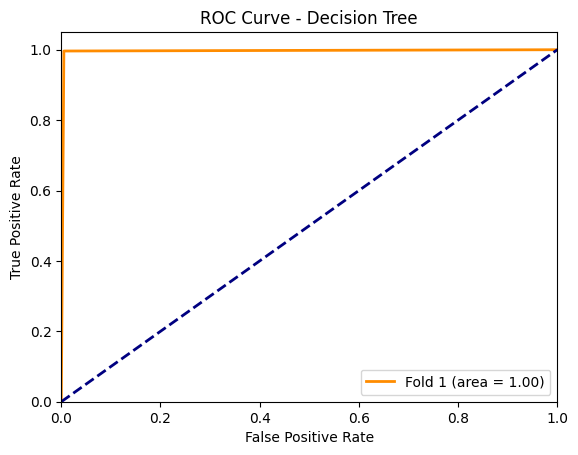

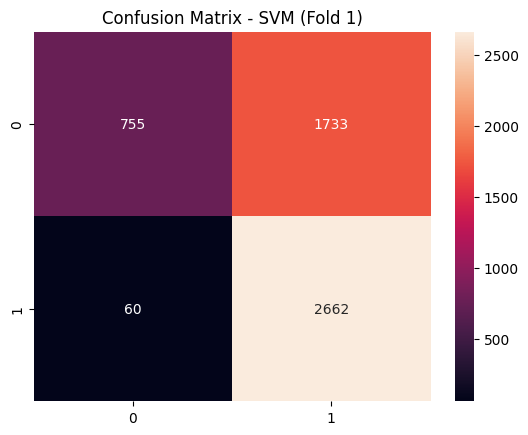

Classification Report - SVM (Fold 1):
              precision    recall  f1-score   support

           0       0.93      0.30      0.46      2488
           1       0.61      0.98      0.75      2722

    accuracy                           0.66      5210
   macro avg       0.77      0.64      0.60      5210
weighted avg       0.76      0.66      0.61      5210



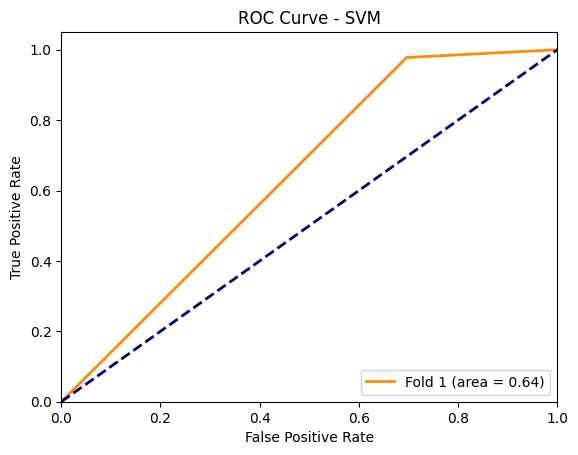

Fold 2 - Decision Tree (J48) Score: 0.97
Fold 2 - SVM Score: 0.60


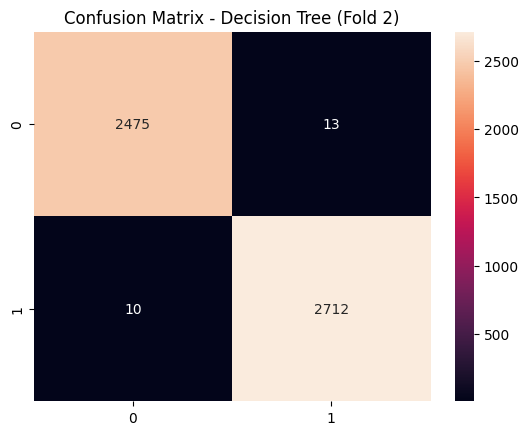

Classification Report - Decision Tree (Fold 2):
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      2488
           1       1.00      1.00      1.00      2722

    accuracy                           1.00      5210
   macro avg       1.00      1.00      1.00      5210
weighted avg       1.00      1.00      1.00      5210



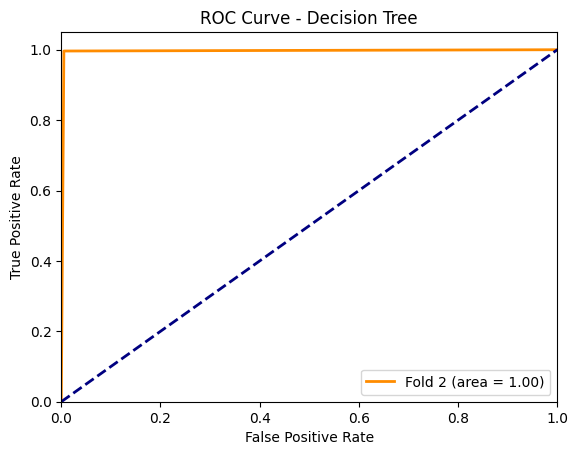

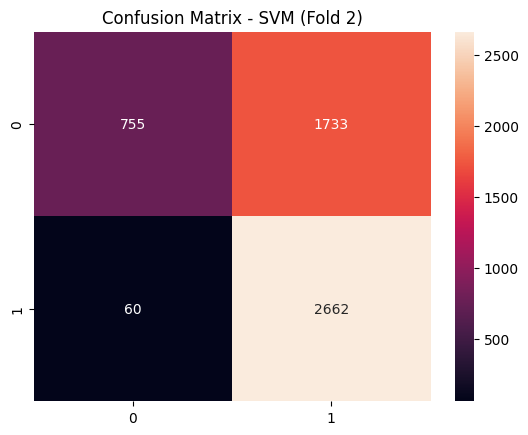

Classification Report - SVM (Fold 2):
              precision    recall  f1-score   support

           0       0.93      0.30      0.46      2488
           1       0.61      0.98      0.75      2722

    accuracy                           0.66      5210
   macro avg       0.77      0.64      0.60      5210
weighted avg       0.76      0.66      0.61      5210



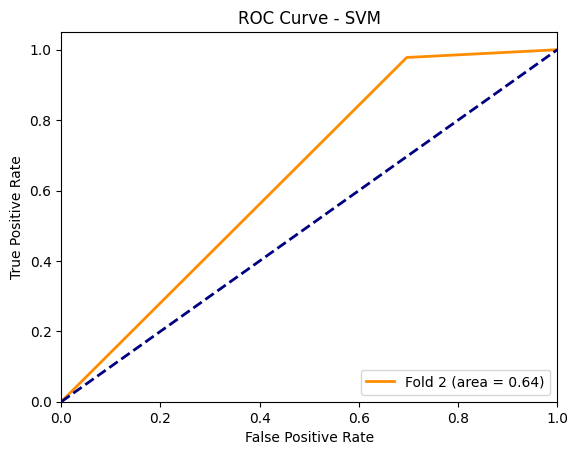

Fold 3 - Decision Tree (J48) Score: 0.98
Fold 3 - SVM Score: 0.54


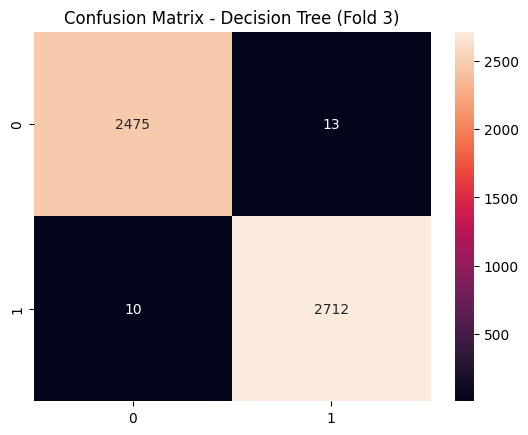

Classification Report - Decision Tree (Fold 3):
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      2488
           1       1.00      1.00      1.00      2722

    accuracy                           1.00      5210
   macro avg       1.00      1.00      1.00      5210
weighted avg       1.00      1.00      1.00      5210



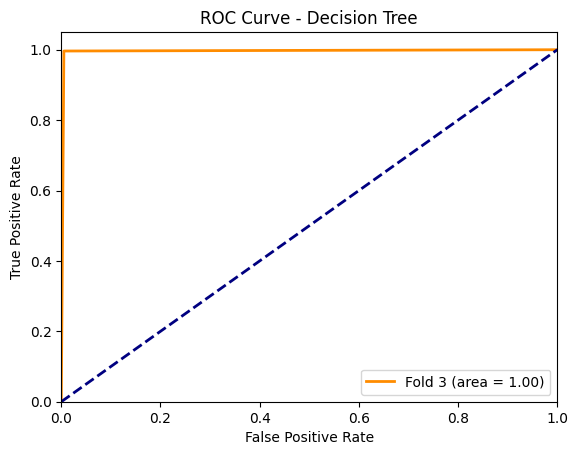

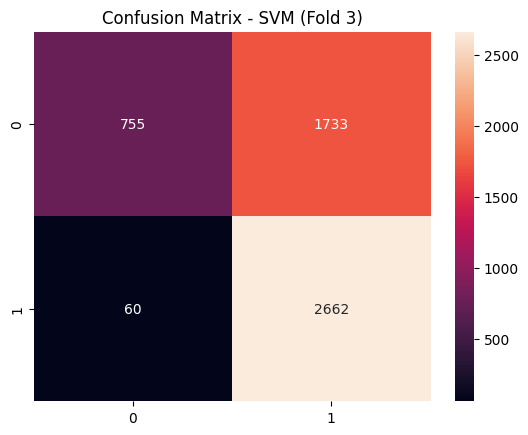

Classification Report - SVM (Fold 3):
              precision    recall  f1-score   support

           0       0.93      0.30      0.46      2488
           1       0.61      0.98      0.75      2722

    accuracy                           0.66      5210
   macro avg       0.77      0.64      0.60      5210
weighted avg       0.76      0.66      0.61      5210



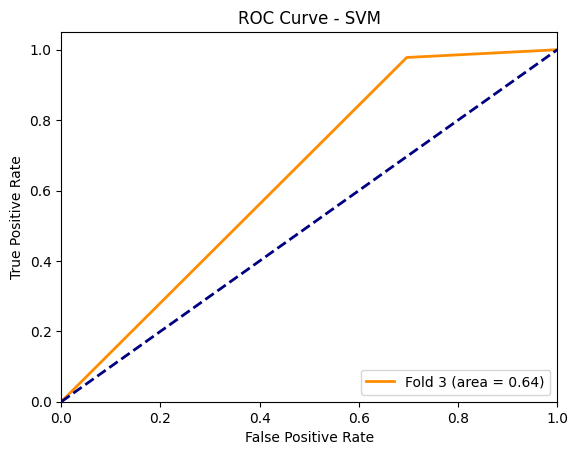

Fold 4 - Decision Tree (J48) Score: 0.97
Fold 4 - SVM Score: 0.54


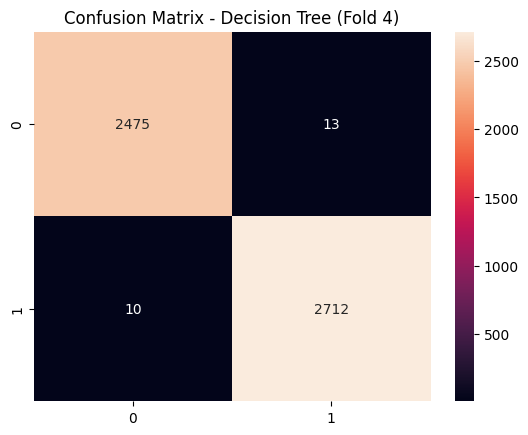

Classification Report - Decision Tree (Fold 4):
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      2488
           1       1.00      1.00      1.00      2722

    accuracy                           1.00      5210
   macro avg       1.00      1.00      1.00      5210
weighted avg       1.00      1.00      1.00      5210



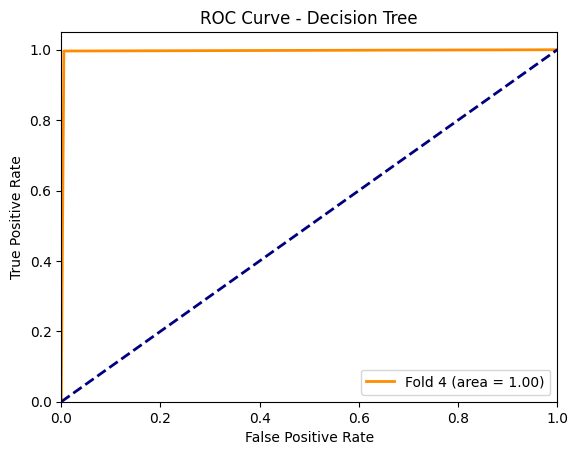

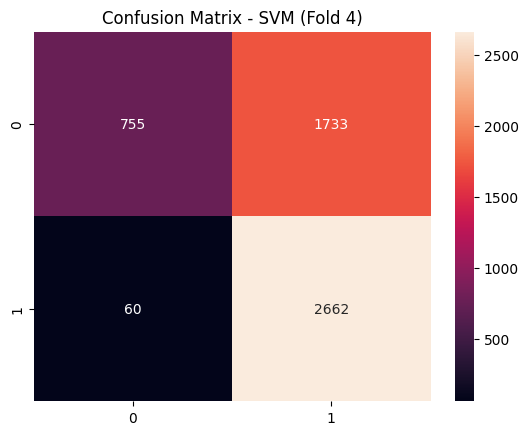

Classification Report - SVM (Fold 4):
              precision    recall  f1-score   support

           0       0.93      0.30      0.46      2488
           1       0.61      0.98      0.75      2722

    accuracy                           0.66      5210
   macro avg       0.77      0.64      0.60      5210
weighted avg       0.76      0.66      0.61      5210



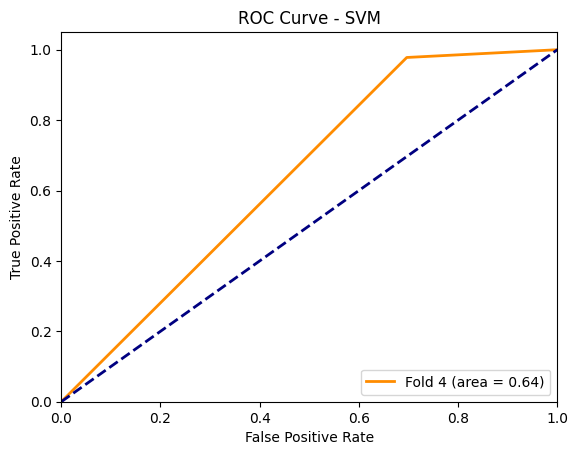

Fold 5 - Decision Tree (J48) Score: 0.98
Fold 5 - SVM Score: 0.53


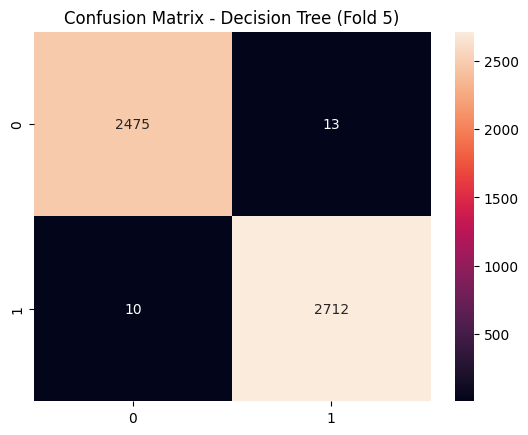

Classification Report - Decision Tree (Fold 5):
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      2488
           1       1.00      1.00      1.00      2722

    accuracy                           1.00      5210
   macro avg       1.00      1.00      1.00      5210
weighted avg       1.00      1.00      1.00      5210



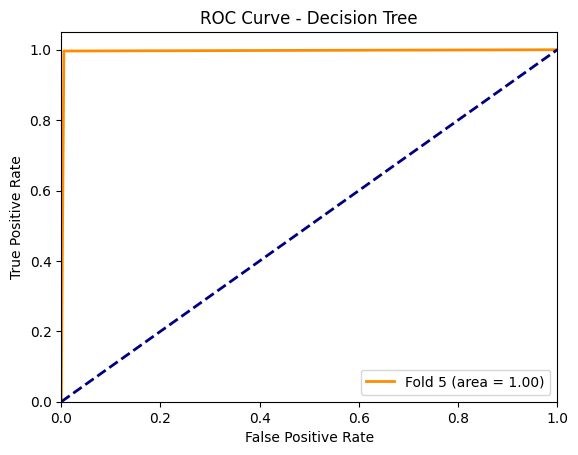

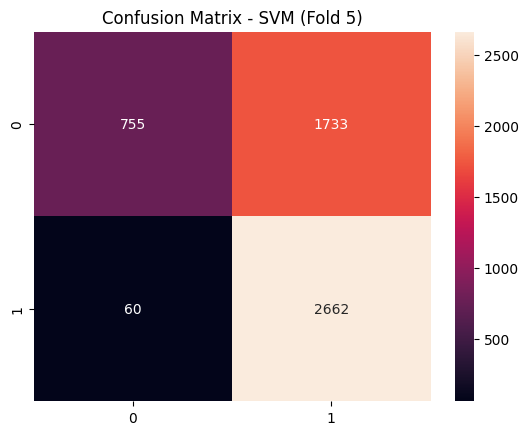

Classification Report - SVM (Fold 5):
              precision    recall  f1-score   support

           0       0.93      0.30      0.46      2488
           1       0.61      0.98      0.75      2722

    accuracy                           0.66      5210
   macro avg       0.77      0.64      0.60      5210
weighted avg       0.76      0.66      0.61      5210



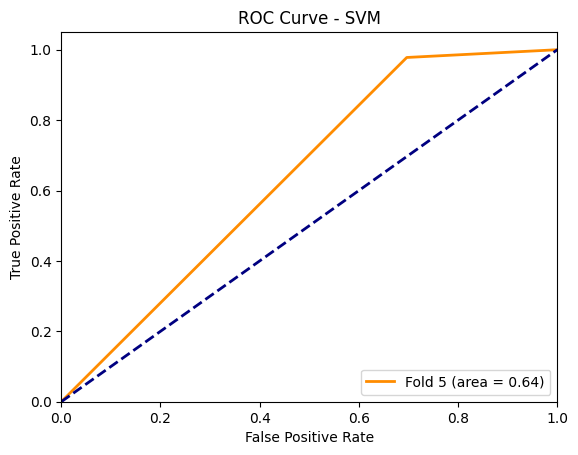

In [274]:
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns

# Load the k-fold results from the pickle file
with open('pkl/kfold_results.pkl', 'rb') as file:
    results = pickle.load(file)
    decision_tree_scores = results['decision_tree_scores']
    svm_scores = results['svm_scores']

# Define function to plot ROC curve


def plot_roc_curve(fpr, tpr, roc_auc, title, label):
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label=f'{label} (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {title}')
    plt.legend(loc='lower right')
    plt.show()


# Loop through each fold and generate metrics
for fold, (dt_score, svm_score) in enumerate(zip(decision_tree_scores, svm_scores)):
    print(f"Fold {fold+1} - Decision Tree (J48) Score: {dt_score:.2f}")
    print(f"Fold {fold+1} - SVM Score: {svm_score:.2f}")

    # Generate confusion matrix for Decision Tree
    dt_pred = decision_tree.predict(X)
    dt_cm = confusion_matrix(y, dt_pred)
    plt.figure()
    sns.heatmap(dt_cm, annot=True, fmt="d")
    plt.title(f"Confusion Matrix - Decision Tree (Fold {fold+1})")
    plt.show()

    # Generate classification report for Decision Tree
    dt_report = classification_report(y, dt_pred)
    print(
        f"Classification Report - Decision Tree (Fold {fold+1}):\n{dt_report}")

    # Generate ROC curve for Decision Tree
    dt_fpr, dt_tpr, _ = roc_curve(y, dt_pred)
    dt_roc_auc = auc(dt_fpr, dt_tpr)
    plot_roc_curve(dt_fpr, dt_tpr, dt_roc_auc,
                   "Decision Tree", f"Fold {fold+1}")

    # Generate confusion matrix for SVM
    svm_pred = svm.predict(X)
    svm_cm = confusion_matrix(y, svm_pred)
    plt.figure()
    sns.heatmap(svm_cm, annot=True, fmt="d")
    plt.title(f"Confusion Matrix - SVM (Fold {fold+1})")
    plt.show()

    # Generate classification report for SVM
    svm_report = classification_report(y, svm_pred)
    print(f"Classification Report - SVM (Fold {fold+1}):\n{svm_report}")

    # Generate ROC curve for SVM
    svm_fpr, svm_tpr, _ = roc_curve(y, svm_pred)
    svm_roc_auc = auc(svm_fpr, svm_tpr)
    plot_roc_curve(svm_fpr, svm_tpr, svm_roc_auc, "SVM", f"Fold {fold+1}")

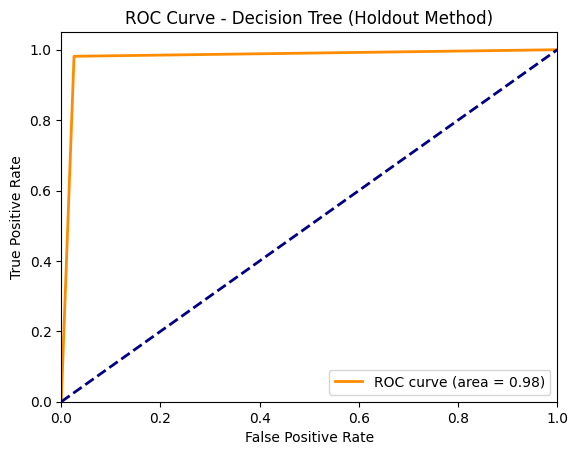

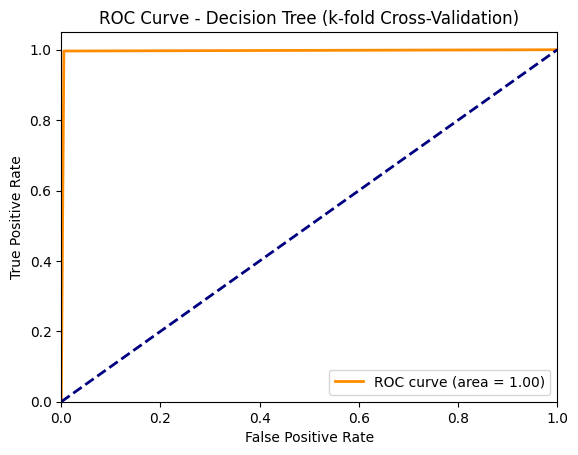

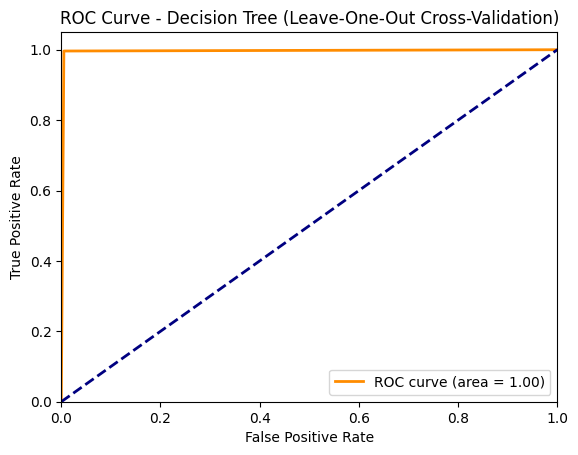

Confusion Matrix - Decision Tree (Holdout Method):
[[493  13]
 [ 10 526]]
Confusion Matrix - Decision Tree (k-fold Cross-Validation):
[[2475   13]
 [  10 2712]]
Confusion Matrix - Decision Tree (Leave-One-Out Cross-Validation):
[[2475   13]
 [  10 2712]]
Classification Report - Decision Tree (Holdout Method):
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       506
           1       0.98      0.98      0.98       536

    accuracy                           0.98      1042
   macro avg       0.98      0.98      0.98      1042
weighted avg       0.98      0.98      0.98      1042

Classification Report - Decision Tree (k-fold Cross-Validation):
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      2488
           1       1.00      1.00      1.00      2722

    accuracy                           1.00      5210
   macro avg       1.00      1.00      1.00      5210
weighted avg       1.00  

In [ ]:
# Load results from the Holdout Method
with open('pkl/holdout_results.pkl', 'rb') as file:
    holdout_results = pickle.load(file)

# Load results from k-fold Cross-Validation
with open('pkl/kfold_results.pkl', 'rb') as file:
    kfold_results = pickle.load(file)

# Load results from Leave-One-Out Cross-Validation
with open('pkl/loocv_results.pkl', 'rb') as file:
    loocv_results = pickle.load(file)

# Extract scores for Decision Tree, SVM, and K-nearest neighbors
decision_tree_scores_holdout = holdout_results['decision_tree_score']
svm_scores_holdout = holdout_results['svm_score']

# Add K-nearest neighbors scores for Holdout Method
decision_tree_scores_kfold = kfold_results['decision_tree_scores']
svm_scores_kfold = kfold_results['svm_scores']

# Add K-nearest neighbors scores for k-fold Cross-Validation
decision_tree_scores_loocv = loocv_results['decision_tree_scores']
svm_scores_loocv = loocv_results['svm_scores']

# Calculate ROC and other metrics for Decision Tree for Holdout Method
fpr_dt_holdout, tpr_dt_holdout, _ = roc_curve(
    y_val, decision_tree.predict_proba(X_val)[:, 1])
roc_auc_dt_holdout = roc_auc_score(y_val, decision_tree.predict(X_val))

# Calculate ROC and other metrics for SVM for Holdout Method
fpr_svm_holdout, tpr_svm_holdout, _ = roc_curve(
    y_val, svm.decision_function(X_val))
roc_auc_svm_holdout = roc_auc_score(y_val, svm.predict(X_val))

# Calculate ROC and other metrics for Decision Tree for k-fold Cross-Validation
fpr_dt_kfold, tpr_dt_kfold, _ = roc_curve(
    y, decision_tree.predict_proba(X)[:, 1])
roc_auc_dt_kfold = roc_auc_score(y, decision_tree.predict(X))

# Calculate ROC and other metrics for SVM for k-fold Cross-Validation
fpr_svm_kfold, tpr_svm_kfold, _ = roc_curve(y, svm.decision_function(X))
roc_auc_svm_kfold = roc_auc_score(y, svm.predict(X))

# Calculate ROC and other metrics for Decision Tree for Leave-One-Out Cross-Validation
fpr_dt_loocv, tpr_dt_loocv, _ = roc_curve(
    y, decision_tree.predict_proba(X)[:, 1])
roc_auc_dt_loocv = roc_auc_score(y, decision_tree.predict(X))

# Calculate ROC and other metrics for SVM for Leave-One-Out Cross-Validation
fpr_svm_loocv, tpr_svm_loocv, _ = roc_curve(y, svm.decision_function(X))
roc_auc_svm_loocv = roc_auc_score(y, svm.predict(X))

# Print ROC curves
plt.figure()
plt.plot(fpr_dt_holdout, tpr_dt_holdout, color='darkorange', lw=2,
         label='ROC curve (area = %0.2f)' % roc_auc_dt_holdout)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree (Holdout Method)')
plt.legend(loc='lower right')
plt.show()


plt.figure()
plt.plot(fpr_dt_kfold, tpr_dt_kfold, color='darkorange', lw=2,
         label='ROC curve (area = %0.2f)' % roc_auc_dt_kfold)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree (k-fold Cross-Validation)')
plt.legend(loc='lower right')
plt.show()


plt.figure()
plt.plot(fpr_dt_loocv, tpr_dt_loocv, color='darkorange', lw=2,
         label='ROC curve (area = %0.2f)' % roc_auc_dt_loocv)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree (Leave-One-Out Cross-Validation)')
plt.legend(loc='lower right')
plt.show()


# Print confusion matrices
print("Confusion Matrix - Decision Tree (Holdout Method):")
print(confusion_matrix(y_val, decision_tree.predict(X_val)))


print("Confusion Matrix - Decision Tree (k-fold Cross-Validation):")
print(confusion_matrix(y, decision_tree.predict(X)))


print("Confusion Matrix - Decision Tree (Leave-One-Out Cross-Validation):")
print(confusion_matrix(y, decision_tree.predict(X)))


# Print classification reports
print("Classification Report - Decision Tree (Holdout Method):")
print(classification_report(y_val, decision_tree.predict(X_val)))


print("Classification Report - Decision Tree (k-fold Cross-Validation):")
print(classification_report(y, decision_tree.predict(X)))

# Add code to print classification reports for SVM and K-nearest neighbors for k-fold